In [1]:
%%bash
pip install pyspark

if [[ ! -f ./train.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
fi

if [[ ! -f ./test.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/test.csv  
fi

In [2]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as fn

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [3]:
train = spark.read.csv('train.csv',inferSchema=True,header=True)
test=spark.read.csv('test.csv',inferSchema=True,header=True)

In [4]:
train.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
test.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [6]:
print(train.toPandas().shape, test.toPandas().shape)

(381109, 12) (127037, 11)


In [7]:
# Check for null values
train.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in train.columns]).show()  

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  0|     0|  0|              0|          0|                 0|          0|             0|             0|                   0|      0|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+



In [8]:
numerical_columns=['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
categorical_columns=['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

In [9]:
train.groupBy([col for col in categorical_columns]).count().show()

+------+---------------+------------------+-----------+--------------+--------+-----+
|Gender|Driving_License|Previously_Insured|Vehicle_Age|Vehicle_Damage|Response|count|
+------+---------------+------------------+-----------+--------------+--------+-----+
|  Male|              1|                 0|   < 1 Year|            No|       1|  172|
|  Male|              1|                 0|  > 2 Years|            No|       0|    4|
|Female|              1|                 1|   < 1 Year|           Yes|       0| 2122|
|  Male|              1|                 0|   1-2 Year|            No|       0| 7277|
|Female|              1|                 0|  > 2 Years|           Yes|       0| 4145|
|  Male|              0|                 0|   1-2 Year|           Yes|       0|  317|
|Female|              1|                 1|   < 1 Year|            No|       1|   14|
|Female|              0|                 0|   < 1 Year|           Yes|       0|    1|
|Female|              0|                 0|  > 2 Years

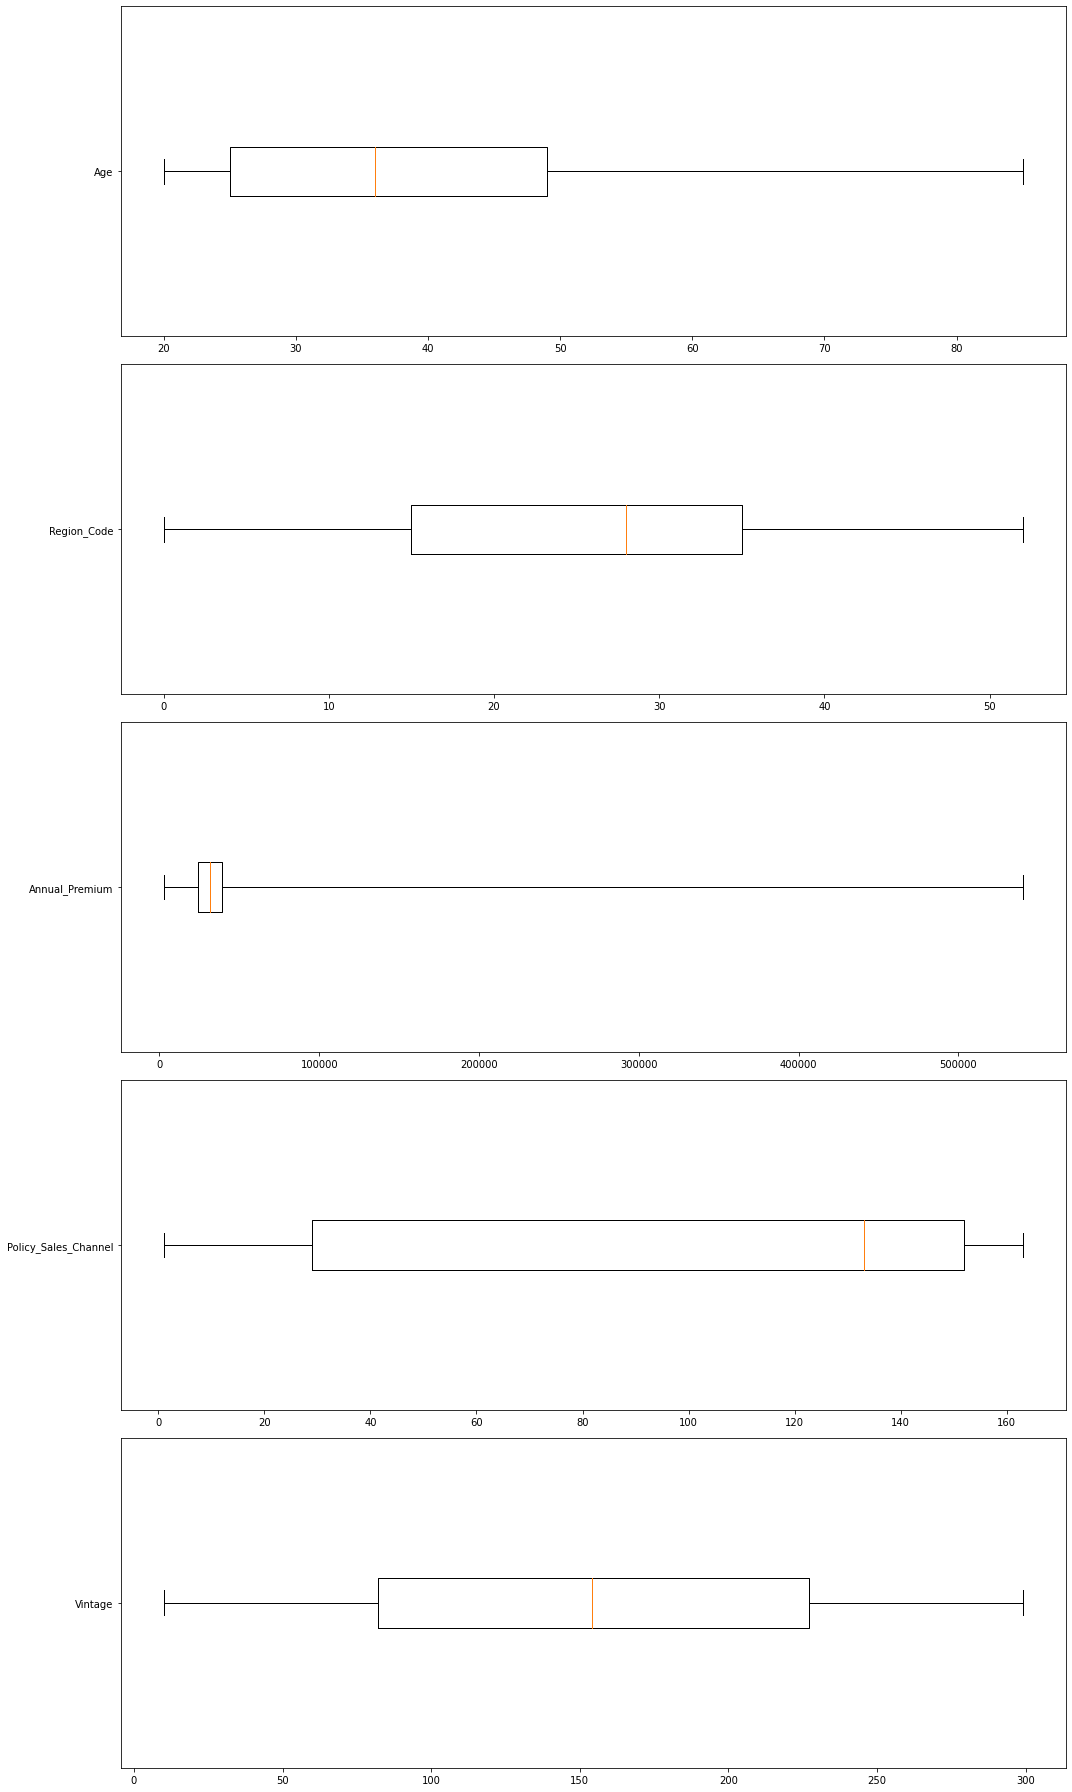

In [10]:
from pyspark.sql import types as t
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
stats =list()
for col_name in numerical_columns:
  percentiles=train.select(col_name).agg(
      fn.expr(f'percentile({col_name},array(0))').alias('0%'),
      fn.expr(f'percentile({col_name},array(0.25))').alias('25%'),
      fn.expr(f'percentile({col_name},array(0.50))').alias('50%'),
      fn.expr(f'percentile({col_name},array(0.75))').alias('75%'),      
      fn.expr(f'percentile({col_name},array(1.00))').alias('100%')).toPandas()
  stats.append({'label': col_name,
                'med': percentiles.loc[0,'50%'],
                'q1': percentiles.loc[0,'25%'], 
                'q3':percentiles.loc[0,'75%'],
                'whislo':percentiles.loc[0,'0%'],
                'whishi':percentiles.loc[0,'100%']})
  
fig, ax = plt.subplots(len(numerical_columns), 1, sharex=False, figsize=(15,25))

for idx, s in enumerate(stats):
  ax[idx].bxp([stats[idx]], vert=False, showfliers=False);

plt.tight_layout()
display()           

In [11]:
# Winsorizing the values to remove outliers 
from pyspark.sql.types import DoubleType,IntegerType,StringType
from pyspark.sql.functions import  array
from pyspark.sql import Row,DataFrame
from functools import reduce
def winsorize(winlow,winhigh):
  def val_winsorize(value):
    if value < winlow:
      return float(winlow)
    if value > head:
      return float(winhigh)
    return float(value)
  return val_winsorize
winsorizefunc = lambda col, winlow, winhigh: fn.udf(winsorize(winlow, winhigh), DoubleType())(col)

for col_name in numerical_columns:
  percentiles=train.select(col_name).agg(
      fn.expr(f'percentile({col_name},array(0.05))').alias('5%'),      
      fn.expr(f'percentile({col_name},array(0.95))').alias('95%')).toPandas()
  winlow=percentiles.loc[0,'5%'][0]
  winhigh=percentiles.loc[0,'95%'][0]
  winsorize_train= train.withColumn(col_name, winsorizefunc(col_name, winlow, winhigh))

**There are no otuliers .However columns like Age and Annual are rightly skewed** 


In [12]:
#Pipeline
from pyspark.ml import  feature, Pipeline, regression, classification, evaluation, tuning
import math

feature_engineering_pipe=Pipeline(stages=[feature.StringIndexerModel().from_labels(['Male', 'Female'],
                                                          inputCol='Gender',outputCol='Gender_Feature'),
                 feature.StringIndexerModel().from_labels(['< 1 Year','> 2 Years','1-2 Year'],
                                                          inputCol='Vehicle_Age',outputCol='Vehicle_Age_feature'),
                 feature.StringIndexerModel().from_labels(['No','Yes'],inputCol='Vehicle_Damage',outputCol='Vehicle_Damage_Feature')])
train_xformed = feature_engineering_pipe.fit(train).transform(train).select(numerical_columns + 
                                                                            ['Driving_License', 'Previously_Insured', 'Response', 
                                                                             fn.col('Gender_Feature').alias('Gender'), 
                                                                             fn.col('Vehicle_Age_Feature').alias('Vehicle_Age'), 
                                                                             fn.col('Vehicle_Damage_Feature').alias('Vehicle_Damage')])

In [25]:
# Applying log transform on skewed data as measurements are different across all dimensions
cols=train_xformed.columns
cols
log_imputer=fn.udf(lambda x:math.log(x+1),DoubleType())

df_xformed=train_xformed.withColumn("Age",log_imputer("Age"))\
                .withColumn("Region_Code",log_imputer("Region_Code"))\
                .withColumn("Annual_Premium",log_imputer("Annual_Premium"))\
                .withColumn("Policy_Sales_Channel",log_imputer("Policy_Sales_Channel"))\
                .withColumn("Vintage",log_imputer("Vintage")).toPandas()
                
df_xformed=feature_engineering_pipe.fit(train_xformed).transform(train_xformed).select(cols)


# **Random Forest**

In [31]:
# Performing train,validation test
train_df,validation_df=df_xformed.randomSplit([0.66,0.33],seed=12)
columns_to_drop = ['Response']
df=df_xformed.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
rf=RandomForestClassifier(labelCol='Response',featuresCol='features')
pipe=Pipeline(stages=[va,rf])
paramGrid=ParamGridBuilder().addGrid(rf.numTrees,[8,20]).addGrid(rf.maxDepth,[10,15]).addGrid(rf.impurity,['gini','entropy']).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
rfCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
rfModel=rfCrossValidator.fit(train_df)

In [32]:
bestModel=rfModel.bestModel
print(f'Number of trees:{bestModel.stages[-1].getNumTrees}') 
print('Max Depth of tree : {}'.format(bestModel.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel.stages[-1].getOrDefault('impurity')))
print('Maximum number of Bins : {}'.format(bestModel.stages[-1].getOrDefault('maxBins')))

Number of trees:20
Max Depth of tree : 10
Best Impurity : entropy
Maximum number of Bins : 32


In [33]:
rf_pred=bestModel.transform(validation_df)
print(f'PR AUC Metric {eval.evaluate(rf_pred)}')
rf_Accuracy=rf_pred.where('Response == prediction').count()/validation_df.count()
print('Accuracy {} '.format(rf_Accuracy))

PR AUC Metric 0.3552896823772358
Accuracy 0.8777850460660609 


In [41]:
import pandas as pd
importance=bestModel.stages[-1].featureImportances
feature=pd.DataFrame(importance.toArray(),columns=['weights'])
feature['feature']=pd.Series(cols)
feature=feature.sort_values(by=['weights'],ascending=False)

<Figure size 1440x1440 with 0 Axes>

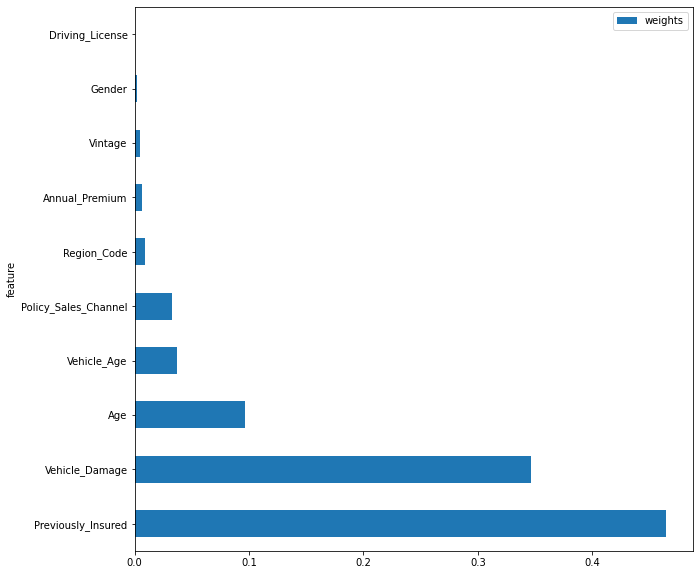

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
feature.plot.barh(x='feature',y='weights',figsize=(10,10),fontsize=10)

# **Gradient Boosting**

In [57]:
# Performing train,validation test
from pyspark.ml.classification import GBTClassifier
train_df,validation_df=df_xformed.randomSplit([0.66,0.33],seed=12)
columns_to_drop = ['Response']
df=df_xformed.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
gbt=GBTClassifier(labelCol='Response',featuresCol='features')
pipe=Pipeline(stages=[va,gbt])
paramGrid=ParamGridBuilder().addGrid(gbt.maxDepth,[10]).addGrid(gbt.maxIter,[15,20,25]).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
gbtCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
gbtModel=gbtCrossValidator.fit(train_df)

In [58]:
bestModel2=gbtModel.bestModel
print('Max Depth of tree {}'.format(bestModel2.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel2.stages[-1].getOrDefault('impurity')))
print('Maximum number of iterations {}'.format(bestModel2.stages[-1].getOrDefault('maxIter')))

Max Depth of tree 10
Best Impurity : variance
Maximum number of iterations 15


In [60]:
gb_pred=bestModel2.transform(validation_df)
print(f'PR AUC Metric : {eval.evaluate(gb_pred)}')
gb_accuracy=gb_pred.where('Response==prediction').count()/validation_df.count()
print(f'Accuracy : {gb_accuracy}')

PR AUC Metric : 0.3539110335477946
Accuracy : 0.8766343797041369


In [67]:
import pandas as pd
importance=bestModel2.stages[-1].featureImportances
feature_gbt=pd.DataFrame(importance.toArray(),columns=['weights'])
feature_gbt['feature']=pd.Series(cols)
feature_gbt=feature_gbt.sort_values(by=['weights'],ascending=False)


<Figure size 1440x1440 with 0 Axes>

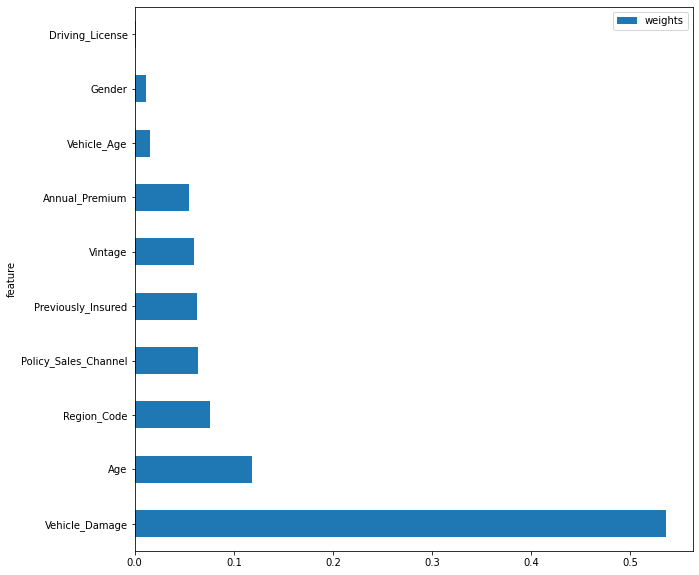

In [69]:
plt.figure(figsize=(20,20))
feature_gbt.plot.barh(x='feature',y='weights',figsize=(10,10),fontsize=10)

# **Decision Tree**

In [72]:
from pyspark.ml.classification import DecisionTreeClassifier
columns_to_drop = ['Response']
df=df_xformed.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
dt=DecisionTreeClassifier(labelCol='Response',featuresCol='features')
pipe=Pipeline(stages=[va,dt])
paramGrid=ParamGridBuilder().addGrid(dt.maxDepth,[10,15]).addGrid(dt.impurity,['gini','entropy']).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
dtCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
dtModel=dtCrossValidator.fit(train_df)

In [74]:
bestModel3=dtModel.bestModel
print('Max Depth of tree {}'.format(bestModel3.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel3.stages[-1].getOrDefault('impurity')))

Max Depth of tree 10
Best Impurity : entropy


In [76]:
dt_pred=bestModel3.transform(validation_df)
print(f'PR AUC Metric : {eval.evaluate(dt_pred)}')
dt_accuracy=dt_pred.where('Response==prediction').count()/validation_df.count()
print(f'Accuracy : {dt_accuracy}')

PR AUC Metric : 0.2929334847485497
Accuracy : 0.8772648818202596


<Figure size 1440x1440 with 0 Axes>

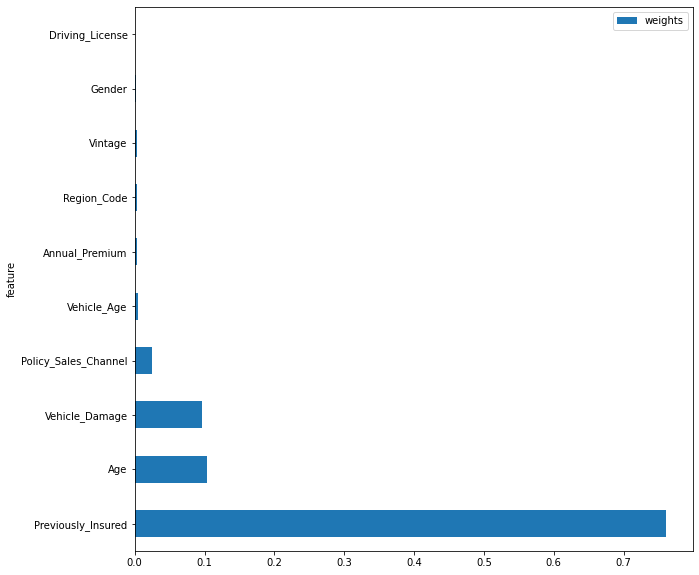

In [77]:
import pandas as pd
importance=bestModel3.stages[-1].featureImportances
feature_dt=pd.DataFrame(importance.toArray(),columns=['weights'])
feature_dt['feature']=pd.Series(cols)
feature_dt=feature_dt.sort_values(by=['weights'],ascending=False)
plt.figure(figsize=(20,20))
feature_dt.plot.barh(x='feature',y='weights',figsize=(10,10),fontsize=10)

Although <i>Region_Code</i> and <i>Policy_Sales_Channel</i> are categorical variables, for exploratory analysis, it is easier to treat them as numerical variables.